### Additional script to reproduce transcript UMAP for case study analysis

In [1]:
# Import necessary libraries
import pandas as pd
from umap import UMAP
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from matplotlib.collections import LineCollection
plt.rcParams['figure.dpi'] = 200

## EDIT THE LINE FOLLOWING LINE ##
path_to_local_zenodo_download_file = 'some_path_to_your_local_copy_of_zenodo_download' 

color_map_path = path_to_local_zenodo_download_file + '/misc_checkpoint_data/colormap_for_cells.pkl'

# Load the color map for cells from a pickle file
with open(color_map_path, 'rb') as file:
    cell_color_final = pickle.load(file)

# Create a list of cell names from the color map
cell_names = list(cell_color_final.keys())
this_label_name = 'Cluster ID (FINAL)'

# Define labels of interest for analysis
labels_of_interest = [
    'Fibroblast.Type.1',
    'Fibroblast.Type.2',
    'Fibroblast.Type.3',
    'Fibroblast.Type.5'
]

# Define labels of interest for analysis (for plot)
labels_for_plot = [
    'CAF1',
    'CAF2',
    'CAF3',
    'CAF4'
]

trans_path = path_to_local_zenodo_download_file + '/misc_checkpoint_data/all_transcripts_both_regions.parquet'
r1_path = path_to_local_zenodo_download_file + '/misc_checkpoint_data/Region_1_Labels.parquet'
r2_path = path_to_local_zenodo_download_file + '/misc_checkpoint_data/Region_2_Labels.parquet'

# Read in the transcript data and labels from parquet files
all_transcripts = pd.read_parquet(trans_path)
r1_labels = pd.read_parquet(r1_path)
r2_labels = pd.read_parquet(r2_path)

In [2]:


# Replace '.' with '-' in all column names of the dataframe
all_transcripts.columns = all_transcripts.columns.str.replace('.', '-', regex=False)

# Extract Region 1 transcripts and clean column names
all_transcripts_r1 = all_transcripts.loc[:, 
    all_transcripts.columns.str.startswith('Region1') | (all_transcripts.columns == 'Unnamed: 0')]
all_transcripts_r1.columns = all_transcripts_r1.columns.str.replace('Region1_R1_', '', regex=False)

# Extract Region 2 transcripts and clean column names
all_transcripts_r2 = all_transcripts.loc[:, 
    all_transcripts.columns.str.startswith('Region2') | (all_transcripts.columns == 'Unnamed: 0')]
all_transcripts_r2.columns = all_transcripts_r2.columns.str.replace('Region2_R2_', '', regex=False)

# Extracting the cell IDs and labels for Region 1 
r1_filtered = r1_labels[r1_labels['group'].isin(labels_of_interest)]
ids_for_R1 = r1_filtered['cell_id'].values
labels_for_R1 = r1_filtered['group'].values

# Extracting the cell IDs and labels for Region 2
r2_filtered = r2_labels[r2_labels['group'].isin(labels_of_interest)]
ids_for_R2 = r2_filtered['cell_id'].values
labels_for_R2 = r2_filtered['group'].values

# Creating the transcript matrices for both regions
transcript_mat_1 = np.zeros((len(ids_for_R1), len(all_transcripts_r1['Unnamed: 0'])))
for i, id in enumerate(ids_for_R1):
    transcript_mat_1[i, :] = all_transcripts_r1[id].values

transcript_mat_2 = np.zeros((len(ids_for_R2), len(all_transcripts_r2['Unnamed: 0'])))
for i, id in enumerate(ids_for_R2):
    transcript_mat_2[i, :] = all_transcripts_r2[id].values

# Combine transcript matrices and labels from both regions
all_transcript_mat = np.vstack([transcript_mat_1, transcript_mat_2])
all_labels = np.hstack([labels_for_R1, labels_for_R2]) 

In [3]:
# Initialize the UMAP model with specified parameters
umap_model = UMAP(
    n_components=2,      # Number of dimensions for the output
    n_neighbors=100,     # Number of neighboring points used in the UMAP algorithm
    min_dist=0.1,       # Minimum distance between points in the low-dimensional space
    metric='manhattan',  # Distance metric to use
    random_state=42      # Seed for reproducibility
)

# Fit the UMAP model to the transcript matrix and transform the data

umap_model.fit(all_transcript_mat)
umap_results = umap_model.transform(all_transcript_mat)


/Users/joshuamoore/miniconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [4]:
from scipy.spatial import distance_matrix
import networkx as nx
from scipy.ndimage import gaussian_filter1d


representative_nodes = np.zeros((len(labels_of_interest),np.shape(all_transcript_mat)[1]))
for i,label in enumerate(labels_of_interest):
    representative_nodes[i,:] = np.median(all_transcript_mat[all_labels==label,:],axis=0)
    
    
# Calculate the distance matrix using Manhattan distance
dist_matrix = distance_matrix(representative_nodes, representative_nodes, p=1)

# Create a graph from the distance matrix
G = nx.from_numpy_array(dist_matrix,nodelist=labels_of_interest)

# Compute the minimum spanning tree
mst = nx.minimum_spanning_tree(G,weight='weight')

edge_list = list(mst.edges(data=False))  

interp_points = 50
trajectory = []
for edge in edge_list:
    
    start = representative_nodes[labels_of_interest.index(edge[0]),:]
    end = representative_nodes[labels_of_interest.index(edge[1]),:]
    these_points = np.linspace(start, end, num=interp_points)
    trajectory.append(these_points)
trajectory = np.vstack(trajectory)

# Project the trajectory onto the UMAP space
projected_trajectory = umap_model.transform(trajectory)

# Smooth the projected trajectory using a Gaussian filter
smoothed_trajectory = gaussian_filter1d(projected_trajectory, sigma=10, axis=0)

# Create segments for visualisation
x = np.asarray(smoothed_trajectory[:, 0])
y = np.asarray(smoothed_trajectory[:, 1])
x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))
coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)


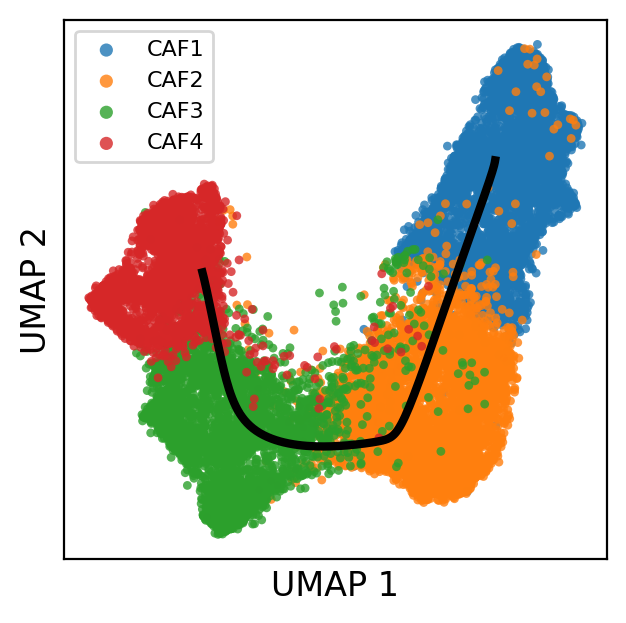

In [5]:
# Set marker size and transparency for the scatter plot
marker_size = 10
alpha = 0.8

# Create a figure and axis for the plot
fig, ax = plt.subplots(figsize=(3.5, 3.5))

# Loop through each label of interest to plot the corresponding data points
for i, label in enumerate(labels_of_interest):
    # Get the indices of the data points that belong to the current label
    indices = np.where(all_labels == label)[0]
    
    # Scatter plot for the current label
    ax.scatter(
        umap_results[indices, 0],  # UMAP 1 coordinates
        umap_results[indices, 1],  # UMAP 2 coordinates
        color=cell_color_final[label],  # Color based on the cell color mapping
        label=labels_for_plot[i],  # Label for the legend
        alpha=alpha,  # Set transparency
        s=marker_size,  # Set marker size
        edgecolors='None',  # No edge color
        linewidths=0  # No line width
    )

# plot the inferred trajectory
ax.plot(smoothed_trajectory[:, 0], smoothed_trajectory[:, 1], color='black', linewidth=3)

# Set axis labels
ax.set_xlabel('UMAP 1', fontsize=12)
ax.set_ylabel('UMAP 2', fontsize=12)

# Remove ticks from the axes
ax.set_xticks([])
ax.set_yticks([])

# Add a legend with specified font size and marker scale
ax.legend(fontsize=8, markerscale=1.5)

# Invert the x-axis for better visualization
ax.invert_xaxis()